<a href="https://colab.research.google.com/github/GuiXu40/deeplearning0/blob/main/basic_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### 1. 导包

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### 2. Encoder
输入 图片
两个卷积层，一个全连接层

In [4]:
class Encoder2(nn.Module):
  """
    the encoder for VAE
  """
  def __init__(self, image_size, input_dim, conv_dims, fc_dim, latent_dim):
    """
      image_size: 图片尺寸
      input_dim: 图片维度
      conv_dims: 卷积层输出的维度（通道数大小）
      fc_dim: 全连接层输入的维度
      latent_dim: 隐变量的维度，也就是encoder最终输出的维度
    """
    super().__init__()

    # 构建卷积层
    convs = []
    prev_dim = input_dim # 初始维度
    for conv_dim in conv_dims:
      convs.append(nn.Sequential(
          nn.Conv2d(prev_dim, conv_dim, kernel_size=3, stride=2, padding=1),
          nn.ReLU()
      ))
      pre_dim = conv_dim
    self.convs = nn.Sequential(*convs)

    # 构建全连接层
    prev_dim = (image_size // (2 ** len(conv_dims))) ** 2 * conv_dims[-1] # 计算展平后的维度
    self.fc = nn.Sequential(
        nn.Linear(prev_dim, fc_dim),
        nn.ReLU(),
    )

    # 得到均值和方差
    self.fc_mu = nn.Linear(fc_dim, latent_dim)
    self.fc_log_var = nn.Linear(fc_dim, latent_dim)

  def forward(self, x):
    x = self.convs(x)
    print(x.shape)
    x = torch.flatten(x, start_dim=1) # 保留通道数
    print(x.shape)
    x = self.fc(x)
    mu = self.fc_mu(x)
    log_var = self.fc_log_var(x)
    return mu, log_var

### 3. Decoder
构建decoder 或者叫 generation model

In [19]:
class Decoder2(nn.Module):
  def __init__(self, latent_dim, image_size, conv_dims, output_dim):
    super().__init__()

    fc_dim = (image_size // (2 ** len(conv_dims))) ** 2 * conv_dims[-1]
    self.fc = nn.Sequential(
        nn.Linear(latent_dim, fc_dim),
        nn.ReLU()
    )
    self.conv_size = image_size // (2 ** len(conv_dims))

    de_convs = []
    prev_dim = conv_dims[-1]
    for conv_dim in conv_dims[::-1]:
      de_convs.append(nn.Sequential(
          nn.ConvTranspose2d(prev_dim, conv_dim, kernel_size=3, stride=2, padding=1, output_padding=1), # 转置卷积
          nn.ReLU()
      ))
      prev_dim = conv_dim
    self.de_convs = nn.Sequential(*de_convs)
    self.pred_layer = nn.Sequential(
        nn.Conv2d(prev_dim, output_dim, kernel_size=3, stride=1, padding=1),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.fc(x)
    x = x.reshape(x.size(0), -1, self.conv_size, self.conv_size)
    x = self.de_convs(x)
    x = self.pred_layer(x)
    return x

In [23]:
class Encoder(nn.Module):
    """The encoder for VAE"""
    
    def __init__(self, image_size, input_dim, conv_dims, fc_dim, latent_dim):
        super().__init__()
        
        convs = []
        prev_dim = input_dim
        for conv_dim in conv_dims:
            convs.append(nn.Sequential(
                nn.Conv2d(prev_dim, conv_dim, kernel_size=3, stride=2, padding=1),
                nn.ReLU()
            ))
            prev_dim = conv_dim
        self.convs = nn.Sequential(*convs)
        
        prev_dim = (image_size // (2 ** len(conv_dims))) ** 2 * conv_dims[-1]
        self.fc = nn.Sequential(
            nn.Linear(prev_dim, fc_dim),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(fc_dim, latent_dim)
        self.fc_log_var = nn.Linear(fc_dim, latent_dim)
                    
    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var
    
class Decoder(nn.Module):
    """The decoder for VAE"""
    
    def __init__(self, latent_dim, image_size, conv_dims, output_dim):
        super().__init__()
        
        fc_dim = (image_size // (2 ** len(conv_dims))) ** 2 * conv_dims[-1]
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, fc_dim),
            nn.ReLU()
        )
        self.conv_size = image_size // (2 ** len(conv_dims))
        
        de_convs = []
        prev_dim = conv_dims[-1]
        for conv_dim in conv_dims[::-1]:
            de_convs.append(nn.Sequential(
                nn.ConvTranspose2d(prev_dim, conv_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU()
            ))
            prev_dim = conv_dim
        self.de_convs = nn.Sequential(*de_convs)
        self.pred_layer = nn.Sequential(
            nn.Conv2d(prev_dim, output_dim, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.fc(x)
        x = x.reshape(x.size(0), -1, self.conv_size, self.conv_size)
        x = self.de_convs(x)
        x = self.pred_layer(x)
        return x
        

#### 4. VAE

In [24]:
class VAE(nn.Module):
  def __init__(self, image_size, input_dim, conv_dims, fc_dim, latent_dim):
    super().__init__()

    self.encoder = Encoder(image_size, input_dim, conv_dims, fc_dim, latent_dim)
    self.decoder = Decoder(latent_dim, image_size, conv_dims, input_dim)

  def sample_z(self, mu, log_var):
    """ sample z by reparameterization trick"""
    std = torch.exp(0.5 * log_var)
    eps = torch.rand_like(std)
    return mu + eps * std

  def forward(self, x):
    mu, log_var = self.encoder(x)
    z = self.sample_z(mu, log_var)
    recon = self.decoder(z)
    return recon, mu, log_var

  def compute_loss(self, x, recon, mu, log_var):

    # KL loss
    kl_loss = (0.5 * (log_var.exp() + mu ** 2 - 1 - log_var)).sum(1).mean()

    # recon loss
    recon_loss = F.binary_cross_entropy(recon, x, reduction="none").sum([1, 2, 3]).mean()

    return recon_loss + kl_loss

### 5. 训练

In [25]:
x = torch.rand(1, 1, 28, 28)

image_size = 28
conv_dims = [32, 64]
fc_dim = 128
latent_dim = 64

batch_size = 128
epochs = 30

transform = transforms.Compose([
    transforms.ToTensor()
])
dataset1 = datasets.MNIST('./data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

model = VAE(image_size, 1, conv_dims, fc_dim, latent_dim).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [26]:
print_freq = 200
for epoch in range(epochs):
  print("start training epoch {}".format(epoch,))
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    recon, mu, log_var = model(images)
    loss = model.compute_loss(images, recon, mu, log_var)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i + 1) % print_freq == 0 or (i + 1) == len(train_loader):
      print("\t [{}/{}]: loss {}".format(i, len(train_loader), loss.item()))

start training epoch 0
	 [199/469]: loss 174.6201629638672
	 [399/469]: loss 112.12305450439453
	 [468/469]: loss 113.97062683105469
start training epoch 1
	 [199/469]: loss 99.67759704589844
	 [399/469]: loss 95.43409729003906
	 [468/469]: loss 95.57394409179688
start training epoch 2
	 [199/469]: loss 91.50697326660156
	 [399/469]: loss 88.53988647460938
	 [468/469]: loss 84.77857971191406
start training epoch 3
	 [199/469]: loss 88.26384735107422
	 [399/469]: loss 90.40848541259766
	 [468/469]: loss 87.64691162109375
start training epoch 4
	 [199/469]: loss 87.90841674804688
	 [399/469]: loss 87.69867706298828
	 [468/469]: loss 86.96977233886719
start training epoch 5
	 [199/469]: loss 85.1392593383789
	 [399/469]: loss 80.72224426269531
	 [468/469]: loss 86.03498077392578
start training epoch 6
	 [199/469]: loss 86.29637908935547
	 [399/469]: loss 85.21422576904297
	 [468/469]: loss 82.74654388427734
start training epoch 7
	 [199/469]: loss 83.81207275390625
	 [399/469]: loss 82.45

### 6. use VAE to generate new images

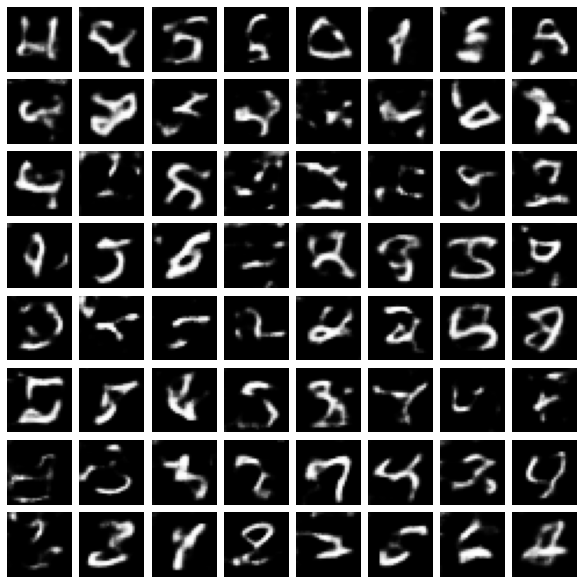

In [27]:
n_cols, n_rows = 8, 8

sample_zs = torch.randn(n_cols * n_rows, latent_dim)
model.eval()
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs.cuda())
    generated_imgs = generated_imgs.cpu().numpy()
generated_imgs = np.array(generated_imgs * 255, dtype=np.uint8).reshape(n_rows, n_cols, image_size, image_size)
    
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(n_rows, n_cols)
for n_col in range(n_cols):
    for n_row in range(n_rows):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs[n_row, n_col], cmap="gray")
        f_ax.axis("off")

0 === torch.Size([128, 1, 28, 28]) === torch.Size([128])
1 === torch.Size([128, 1, 28, 28]) === torch.Size([128])
2 === torch.Size([128, 1, 28, 28]) === torch.Size([128])
3 === torch.Size([128, 1, 28, 28]) === torch.Size([128])
4 === torch.Size([128, 1, 28, 28]) === torch.Size([128])
5 === torch.Size([128, 1, 28, 28]) === torch.Size([128])
6 === torch.Size([128, 1, 28, 28]) === torch.Size([128])
7 === torch.Size([128, 1, 28, 28]) === torch.Size([128])
8 === torch.Size([128, 1, 28, 28]) === torch.Size([128])
9 === torch.Size([128, 1, 28, 28]) === torch.Size([128])
10 === torch.Size([128, 1, 28, 28]) === torch.Size([128])
11 === torch.Size([128, 1, 28, 28]) === torch.Size([128])
12 === torch.Size([128, 1, 28, 28]) === torch.Size([128])
13 === torch.Size([128, 1, 28, 28]) === torch.Size([128])
14 === torch.Size([128, 1, 28, 28]) === torch.Size([128])
15 === torch.Size([128, 1, 28, 28]) === torch.Size([128])
16 === torch.Size([128, 1, 28, 28]) === torch.Size([128])
17 === torch.Size([128, 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


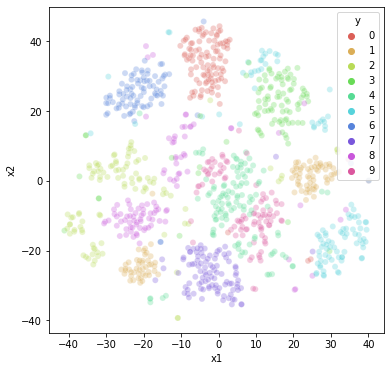

In [30]:
## visualize latent features

latent_zs = []
targets = []
for i, (images, labels) in enumerate(train_loader):
  print(i , "===" , images.shape, "===", labels.shape)
  images = images.cuda()
  with torch.no_grad():
      mu, log_var = model.encoder(images)
  latent_zs.append(mu.cpu().numpy())
  targets.append(labels.numpy())
latent_zs = np.concatenate(latent_zs, 0)
targets = np.concatenate(targets, 0)

n_samples = 1000
sample_idxs = np.random.permutation(len(targets))[:n_samples]

latent_zs = latent_zs[sample_idxs]
targets = targets[sample_idxs]
zs_reduced = TSNE(n_components=2, random_state=2022).fit_transform(latent_zs)

tsne_data = pd.DataFrame({
    "x1": zs_reduced[:,0],
    "x2": zs_reduced[:,1],
    "y": targets})

plt.figure(figsize=(6, 6))
sns.scatterplot(
    x="x1", y="x2",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=tsne_data,
    legend="full",
    alpha=0.3
)   